In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results CSV 
results_path = '../results/main/Helpfulness_prediction.csv'
df = pd.read_csv(results_path)

# Just to show from the 8 only first three targets: MH9A, MH9B, MH9C
filtered_df = df[df['Target'].isin(['MH9A', 'MH9B', 'MH9C'])]


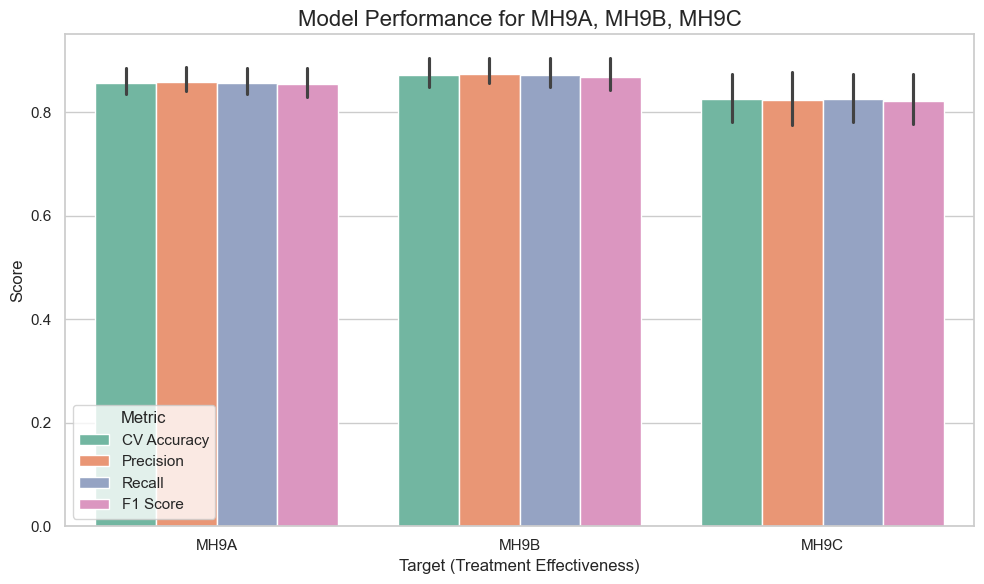

In [2]:
# Set the figure size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Melt the data for easier plotting
melted_df = pd.melt(filtered_df, id_vars=["Target"], value_vars=["CV Accuracy", "Precision", "Recall", "F1 Score"], 
                    var_name="Metric", value_name="Score")

# Create a bar plot for each target and metric
sns.barplot(data=melted_df, x="Target", y="Score", hue="Metric", palette="Set2")

# Add title and labels
plt.title("Model Performance for MH9A, MH9B, MH9C", fontsize=16)
plt.xlabel("Target (Treatment Effectiveness)", fontsize=12)
plt.ylabel("Score", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


2025-04-10 02:21:40,897 - INFO - Dataset loaded successfully from c:\Users\Bely\Documents\Bar-llan\ML\ML_Final_Project\data\processed_data_helpfulness.csv. Shape: (22474, 68)


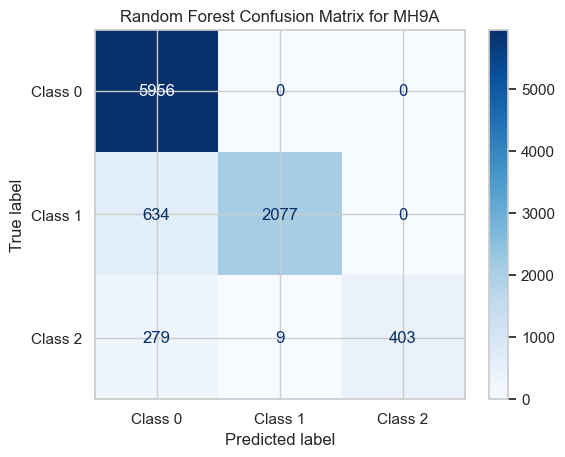

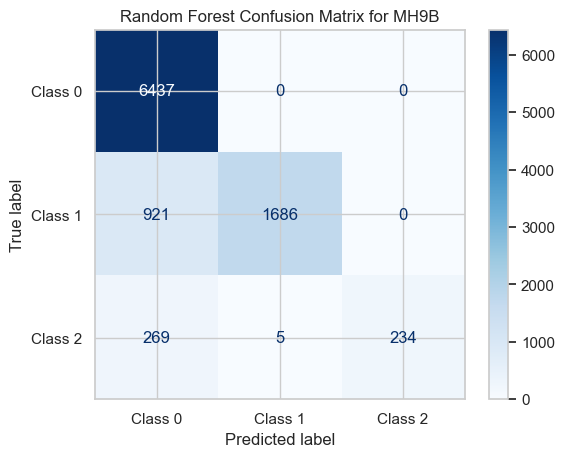

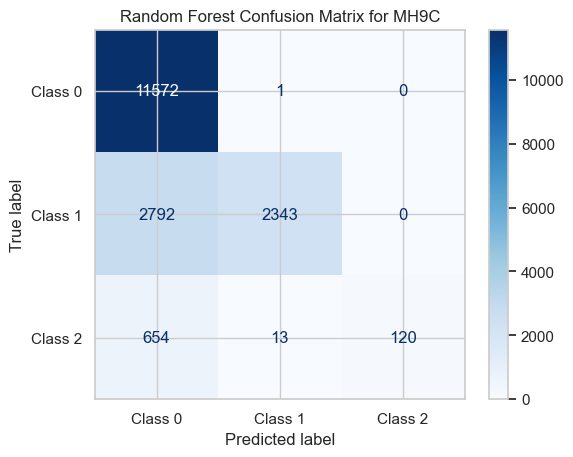

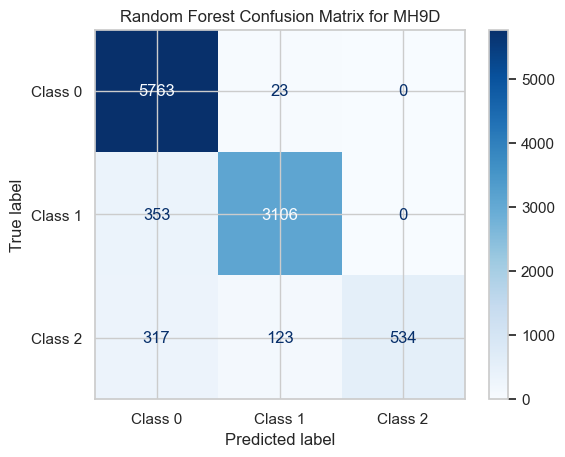

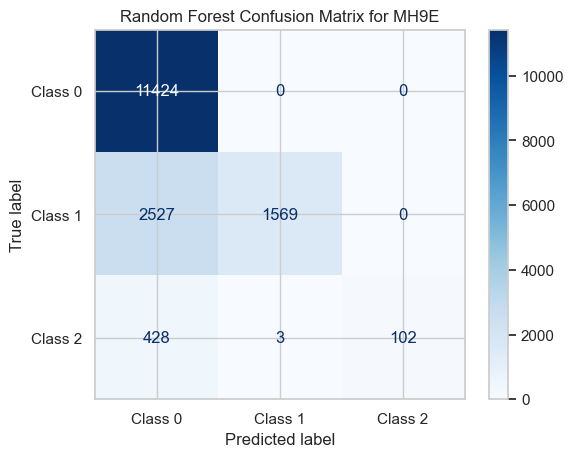

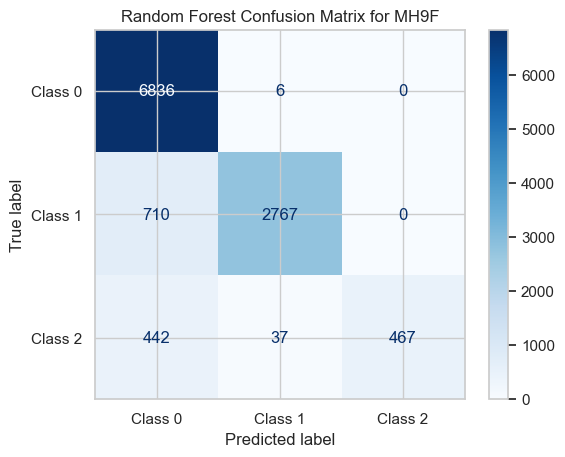

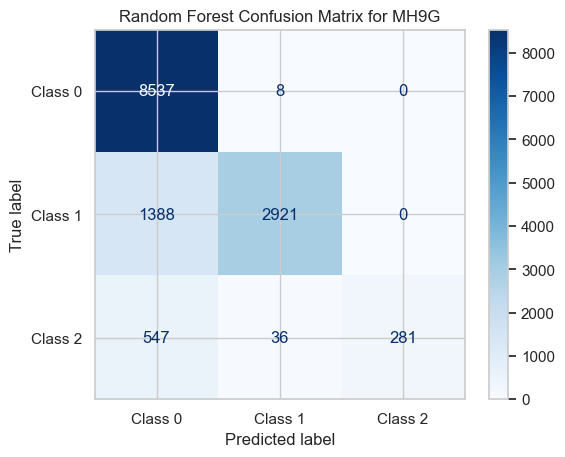

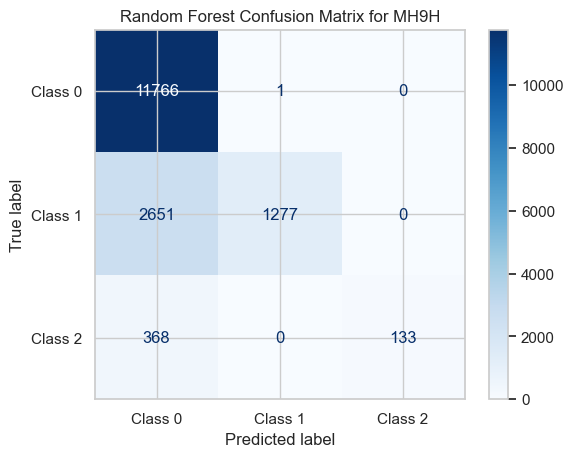

c:\Users\Bely\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\Bely\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


: 

: 

In [ ]:
import os
import pandas as pd
from logg import logger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath('../src'))
from Helpfulness_Training import random_forest, neural_network, xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Define the data path
data_path = os.path.abspath('../data/processed_data_helpfulness.csv')

def insert_model_separator(model_name):
    """Creates a labeled separator row for CSV readability."""
    return pd.DataFrame([[f"----- {model_name} -----", "", "", "", ""]], 
                        columns=["Target", "Accuracy", "Precision", "Recall", "F1 Score"])

def plot_confusion_matrix(model, X, y, model_name, target_name):
    """Plots the confusion matrix for a given model."""
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(len(set(y)))] )
    cmd.plot(cmap='Blues', values_format='d')
    plt.title(f"{model_name} Confusion Matrix for {target_name}")
    plt.show()

def main():
    try:
        # Load the dataset
        df = pd.read_csv(data_path)
        logger.info(f"Dataset loaded successfully from {data_path}. Shape: {df.shape}")
        
        # Define target columns
        target_columns = ['MH9A', 'MH9B', 'MH9C', 'MH9D', 'MH9E', 'MH9F', 'MH9G', 'MH9H']

        # Run Random Forest Model and plot confusion matrix
        rf_results = random_forest(df, target_columns)
        for target in target_columns:
            rf_model = RandomForestClassifier(n_estimators=100, max_depth=14, random_state=42)
            filtered_data = df[df[target].isin([0, 1, 2])]
            X, y = filtered_data.drop(columns=target_columns), filtered_data[target]
            rf_model.fit(X, y)
            plot_confusion_matrix(rf_model, X, y, "Random Forest", target)

        # Run Neural Network Model and plot confusion matrix
        nn_results = neural_network(df, target_columns)
        for target in target_columns:
            nn_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=2000, random_state=42)
            filtered_data = df[df[target].isin([0, 1, 2])]
            X, y = filtered_data.drop(columns=target_columns), filtered_data[target]
            nn_model.fit(X, y)
            plot_confusion_matrix(nn_model, X, y, "Neural Network", target)

        # Run XGBoost Model and plot confusion matrix
        xgb_results = xgboost(df, target_columns)
        for target in target_columns:
            xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
            filtered_data = df[df[target].isin([0, 1, 2])]
            X, y = filtered_data.drop(columns=target_columns), filtered_data[target]
            xgb_model.fit(X, y)
            plot_confusion_matrix(xgb_model, X, y, "XGBoost", target)

        # Combine results with separators
        final_results = pd.concat([ 
            insert_model_separator("Random Forest"),
            rf_results,
            insert_model_separator("Neural Network"),
            nn_results,
            insert_model_separator("XGBoost"),
            xgb_results
        ], ignore_index=True)

        # Save to CSV
        os.makedirs("./results/main", exist_ok=True)
        output_path = "./results/main/Helpfulness_prediction.csv"
        final_results.to_csv(output_path, index=False)

        logger.info(f"\nResults saved to: {output_path}")
        logger.info("Model training and saving completed successfully.")

    except FileNotFoundError:
        logger.error(f"File not found: {data_path}. Please check the file path.")
    except Exception as e:
        logger.error(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()


2025-04-10 03:53:08,646 - INFO - Dataset loaded successfully from c:\Users\Bely\Documents\Bar-llan\ML\ML_Final_Project\data\processed_data_helpfulness.csv. Shape: (22474, 68)


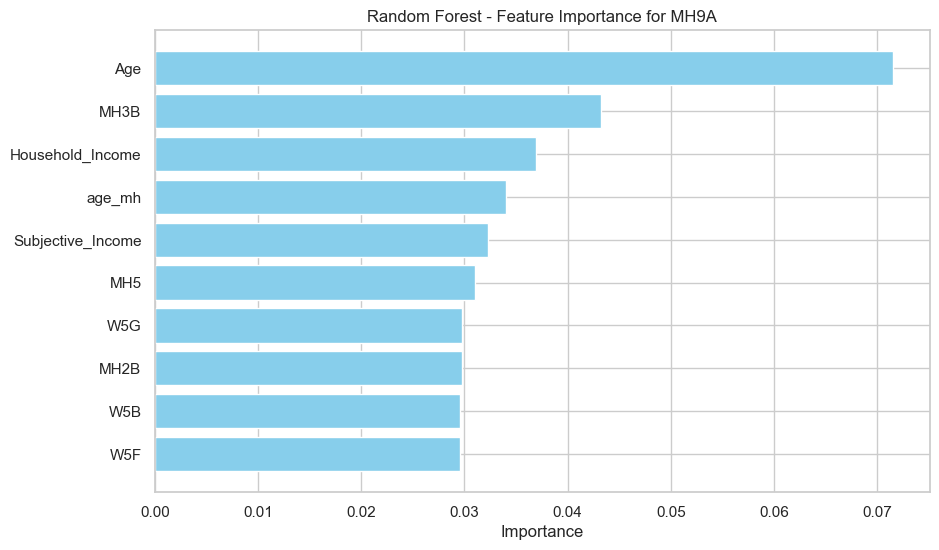

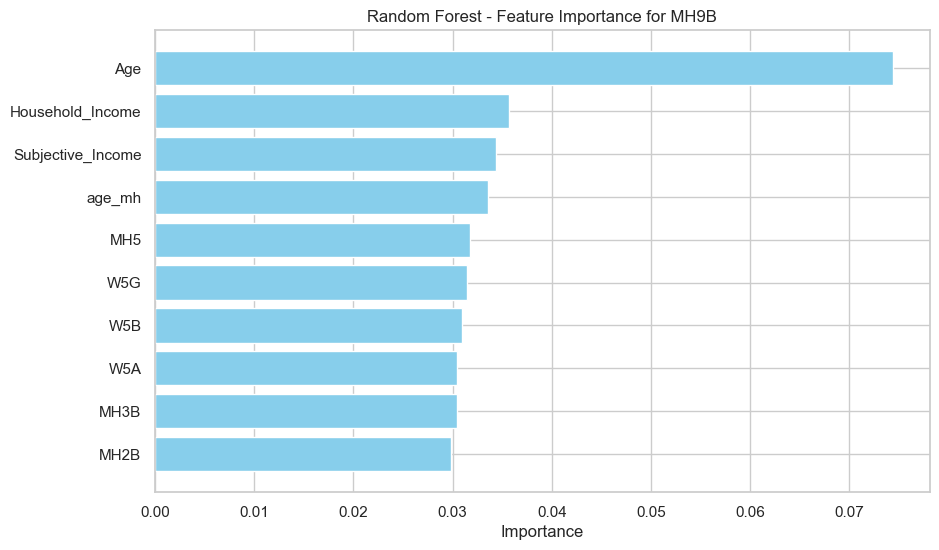

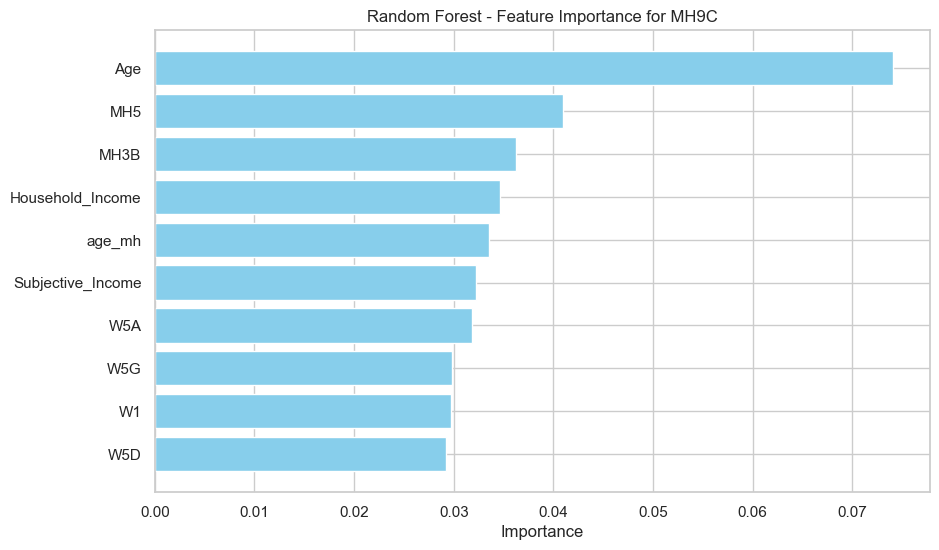

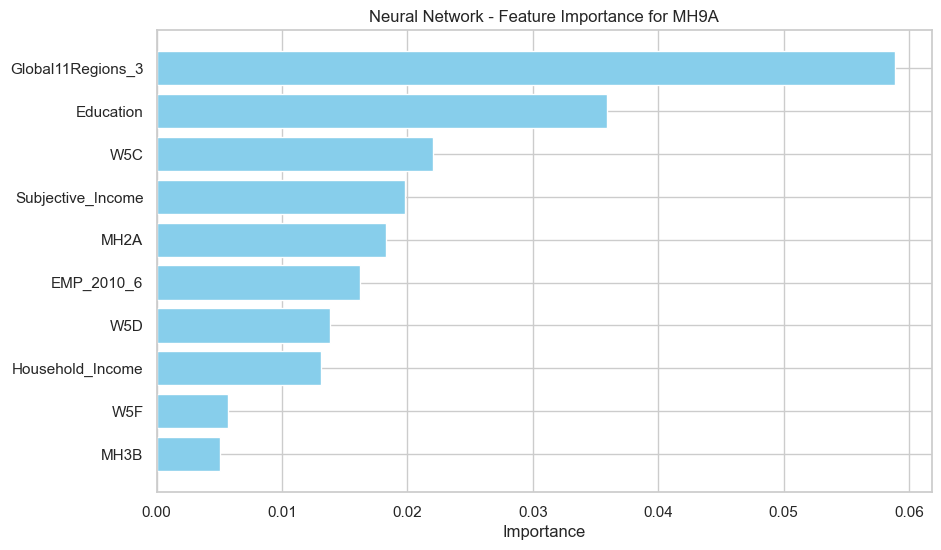

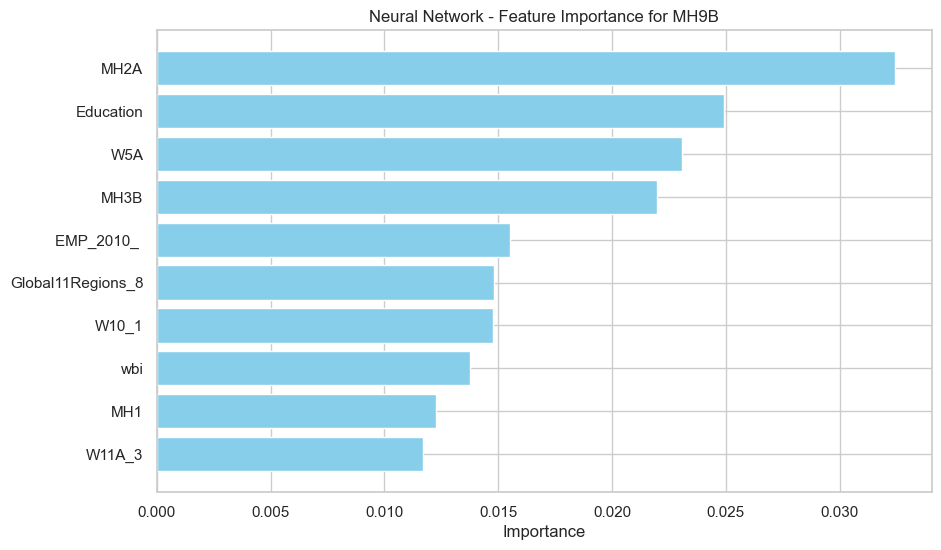

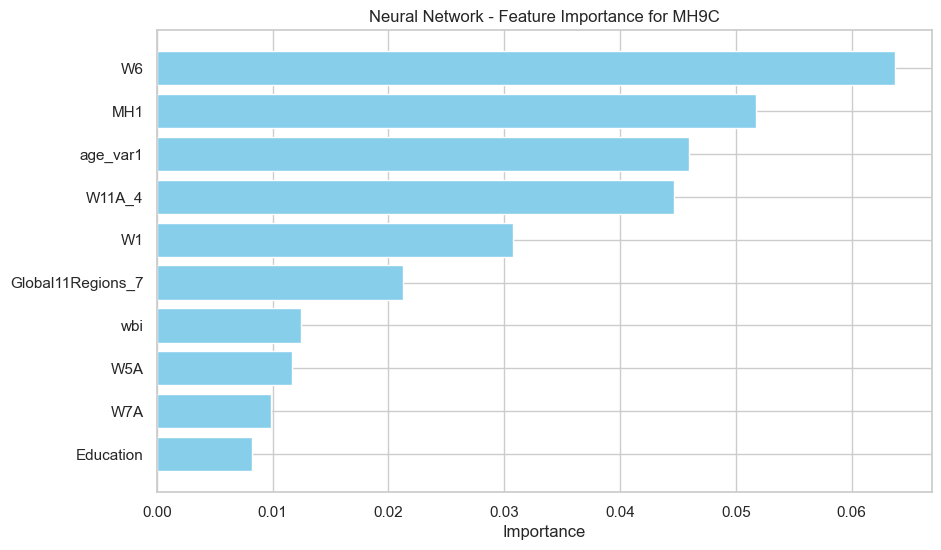

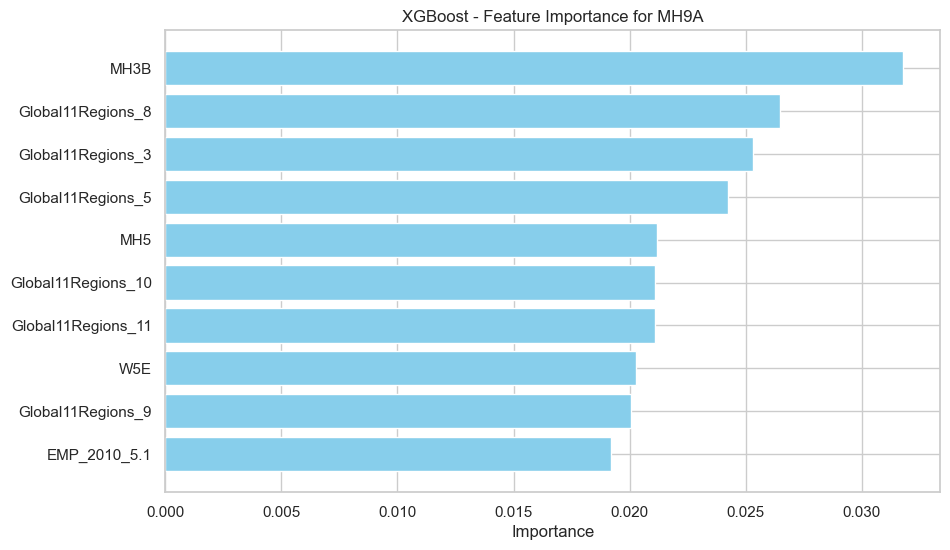

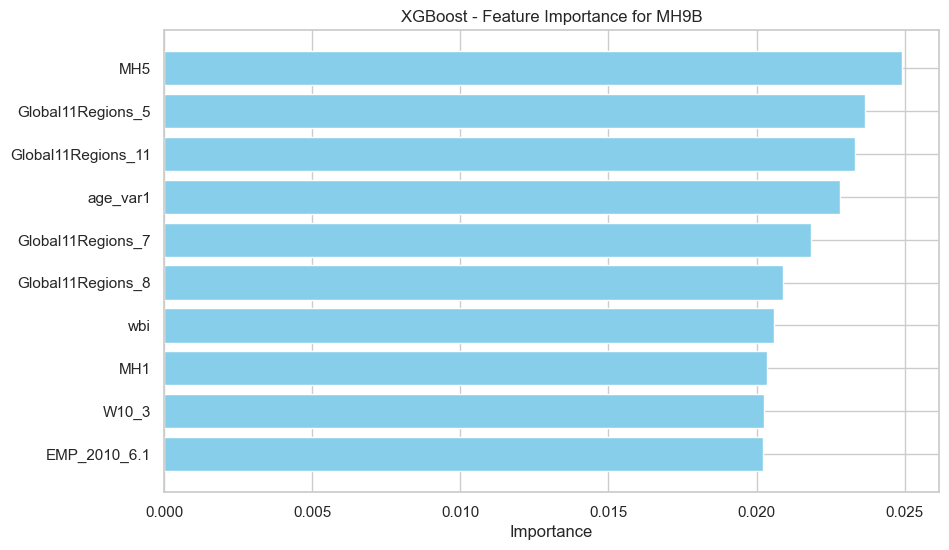

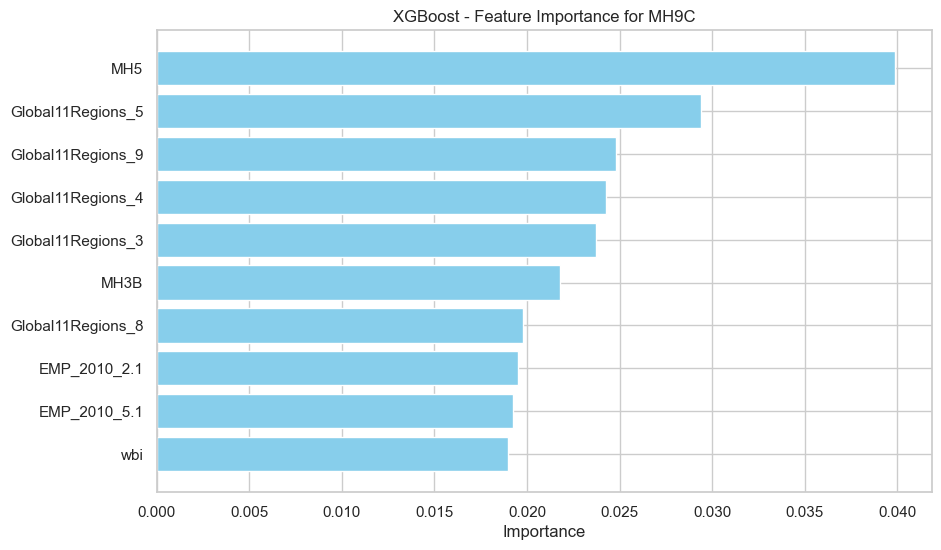

2025-04-10 03:55:15,225 - INFO - Model training and plotting completed successfully.


In [5]:
import os
import pandas as pd
from logg import logger
import matplotlib.pyplot as plt
import sys

# Add the path to the src directory
sys.path.append(os.path.abspath('../src'))

# Import models
from Helpfulness_Training import random_forest, neural_network, xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Define the data path
data_path = os.path.abspath('../data/processed_data_helpfulness.csv')

def plot_feature_importance(model, X, model_name, target_name):
    """Plots feature importance for Random Forest, Neural Network, and XGBoost models."""
    # For Random Forest
    if isinstance(model, RandomForestClassifier):
        feature_importance = model.feature_importances_
    # For XGBoost
    elif isinstance(model, xgb.XGBClassifier):
        feature_importance = model.feature_importances_
    # For Neural Network (using the weights of each feature)
    elif isinstance(model, MLPClassifier):
        feature_importance = model.coefs_[0].mean(axis=1)  # Take the mean of the first layer weights
    
    # Create a dataframe of feature importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')  # Show top 10 features
    plt.xlabel('Importance')
    plt.title(f"{model_name} - Feature Importance for {target_name}")
    plt.gca().invert_yaxis()  # To show the most important feature at the top
    plt.show()

def main():
    try:
        # Load the dataset
        df = pd.read_csv(data_path)
        logger.info(f"Dataset loaded successfully from {data_path}. Shape: {df.shape}")
        
        # Define target columns (only select a subset for feature importance)
        selected_targets = ['MH9A', 'MH9B', 'MH9C']  # Select 3 targets for the analysis
        all_target_columns = ['MH9A', 'MH9B', 'MH9C', 'MH9D', 'MH9E', 'MH9F', 'MH9G', 'MH9H']  # All target columns

        # Run Random Forest Model and plot feature importance for each target
        for target in selected_targets:
            rf_model = RandomForestClassifier(n_estimators=100, max_depth=14, random_state=42)
            # Exclude all target columns from the features (not just the current target)
            filtered_data = df[df[target].isin([0, 1, 2])]  # Only use rows with target in [0, 1, 2]
            X, y = filtered_data.drop(columns=all_target_columns), filtered_data[target]  # Drop all target columns from features
            rf_model.fit(X, y)
            plot_feature_importance(rf_model, X, "Random Forest", target)

        # Run Neural Network Model and plot feature importance for each target
        for target in selected_targets:
            nn_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=2000, random_state=42)
            # Exclude all target columns from the features (not just the current target)
            filtered_data = df[df[target].isin([0, 1, 2])]  # Only use rows with target in [0, 1, 2]
            X, y = filtered_data.drop(columns=all_target_columns), filtered_data[target]  # Drop all target columns from features
            nn_model.fit(X, y)
            plot_feature_importance(nn_model, X, "Neural Network", target)

        # Run XGBoost Model and plot feature importance for each target
        for target in selected_targets:
            xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
            # Exclude all target columns from the features (not just the current target)
            filtered_data = df[df[target].isin([0, 1, 2])]  # Only use rows with target in [0, 1, 2]
            X, y = filtered_data.drop(columns=all_target_columns), filtered_data[target]  # Drop all target columns from features
            xgb_model.fit(X, y)
            plot_feature_importance(xgb_model, X, "XGBoost", target)

        logger.info("Model training and plotting completed successfully.")

    except FileNotFoundError:
        logger.error(f"File not found: {data_path}. Please check the file path.")
    except Exception as e:
        logger.error(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()
